In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as  np
from scipy import signal
from scipy import fft
import scipy
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from IPython.display import HTML
import datetime
import math

In [2]:
data_path = "..\\Datasets\\Forecasting_aqua\\ctd_meteo_aua_2019to2021_V2.csv"
format = "%d-%m-%Y"
df = pd.read_csv(data_path)
time_df = pd.to_datetime(df["Datetime"], format=format)
try:
    df.drop("sample",axis=1,inplace=True)
except:
    pass
df['Datetime']= time_df
keys_imp = ['ciliate','mean_chla','cv_chla_day','cv_chla_depth',
            'nauplius','Ammonium','Nitrat','mean_schmidt','windspeed_max',
            'mean_thermocline_depth','mean_epi_temp','mean_oxycline_depth',
            'mean_mixed_layer_depth','mean_global_radiation'
           ]
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
#drop the first datapoints the first months are only meteorological data
first_point = (~df['mean_chla'].isnull()).idxmax()
dfs = df.drop(index=range(first_point))
df = dfs.reset_index(drop=True)

In [3]:
#prepare the tickslabels
months=[]
fday = []
for day in range(1,366):
    dstr = str(day)
    date = datetime.datetime.strptime("2019-" + dstr, "%Y-%j")
    months.append(date.strftime("%b"))
months,fday = np.unique(months,return_index=True)
#the months are not in order, but the ticks are still correct
print(months)
print(fday)

['Apr' 'Aug' 'Dec' 'Feb' 'Jan' 'Jul' 'Jun' 'Mar' 'May' 'Nov' 'Oct' 'Sep']
[ 90 212 334  31   0 181 151  59 120 304 273 243]


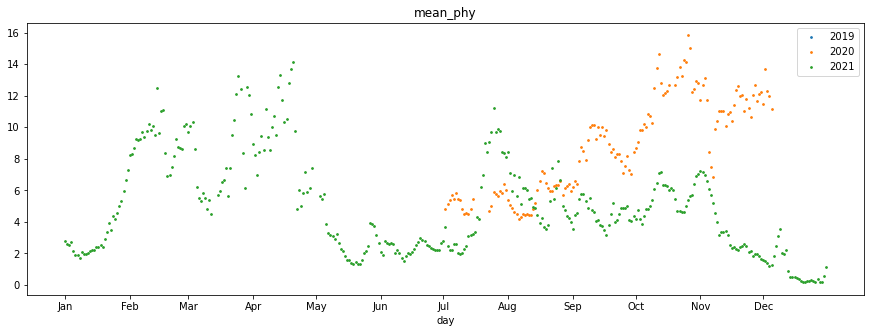

In [4]:
key = 'mean_phy'
fig,ax = plt.subplots(1,figsize=(15,5))

years = df['year'].unique()
for year in years:
    dfy = df[df['year']==year]
    yeardt = np.datetime64(str(year),'Y')
    n_days = (dfy['Datetime']-yeardt).dt.days
    ax.scatter(n_days,dfy[key],s=3)
ax.legend([str(year) for year in years])
ax.set_title(key)
ax.set_xlabel("day")
ax.set_xticks(fday)
ax.set_xticklabels(months)
plt.show()

[]

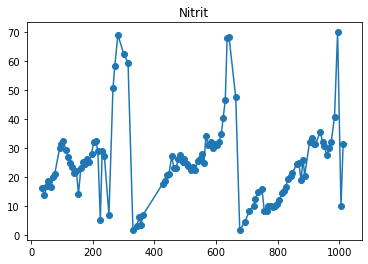

In [5]:
#interpolation
key='Nitrit'
#dfd = df.drop('Datetime',axis=1)
keys_float = df.keys().drop('Datetime')
dfci = df.copy()
dfcin = df.copy()
dfi = df[keys_float].interpolate(method='linear', limit_direction='forward', axis=0)
dfci[keys_float] = dfi-dfi.mean()
dfcin[keys_float] = dfci[keys_float]/dfci[keys_float].std()
dfci = dfci.fillna(0)
dfcin = dfcin.fillna(0)
plt.scatter(np.arange(len(df)),df[key])
plt.plot(np.arange(len(dfi)),dfi[key])
plt.title(key)
plt.plot()

In [6]:
dfcin['mean_phy']

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1020   -1.665719
1021   -1.707491
1022   -1.723549
1023   -1.597422
1024   -1.444465
Name: mean_phy, Length: 1025, dtype: float64

## Fourier transform of each variable

In [7]:
#example of data recovery:
T = 365 # period 
N = 365*3+100
n = N-100
sin = np.array([
    math.sin(math.pi*x*2/T)
    for x in range(N)
])
ft_sine = scipy.fft.rfft(sin,n=n)

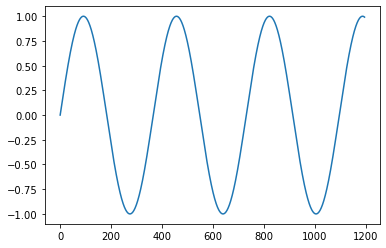

In [8]:
plt.plot(sin)

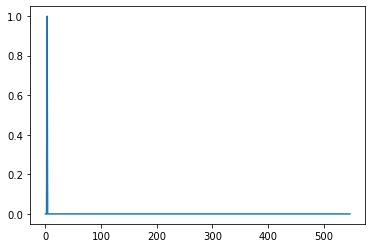

In [9]:
plt.plot(np.abs(ft_sine)/len(ft_sine))

In [10]:
(N)/np.argmax(np.abs(ft_sine))

398.3333333333333

The period is not perfectly recovered due to the finite number of points

In [11]:
len(dfcin)%365

295

In [12]:
ft = scipy.fft.rfft(dfcin[keys_float],axis=0)
fte = (ft*ft.conj()).real

In [13]:
idxk = {}
for idx, key in enumerate(keys_float):
    print(f"{idx}: {key}")
    idxk[key]=idx

0: asplanchna
1: asterionella
2: brachionus
3: diatom_chain
4: dinobryon
5: eudiaptomus
6: kellikottia
7: keratella_quadrata
8: nauplius
9: polyarthra
10: rotifers
11: synchaeta
12: ceratium
13: cyclops
14: fragilaria
15: keratella_cochlearis
16: paradileptus
17: bosmina
18: daphnia
19: trichocerca
20: conochilus
21: diaphanosoma
22: uroglena
23: leptodora
24: chaoborus
25: aphanizomenon
26: cluster_1
27: cluster_2
28: cluster_3
29: cluster_4
30: cluster_5
31: cluster_6
32: cluster_7
33: cluster_8
34: diatom
35: ciliate
36: mean_temp
37: cv_temp_day
38: cv_temp_depth
39: mean_condF
40: cv_condF_day
41: cv_condF_depth
42: mean_o2
43: cv_o2_day
44: cv_o2_depth
45: mean_o2ppm
46: cv_o2ppm_day
47: cv_o2ppm_depth
48: mean_ph
49: cv_ph_day
50: cv_ph_depth
51: mean_chla
52: cv_chla_day
53: cv_chla_depth
54: mean_turb
55: cv_turb_day
56: cv_turb_depth
57: mean_phycoer
58: cv_phycoer_day
59: cv_phycoer_depth
60: mean_par
61: cv_par_day
62: cv_par_depth
63: mean_phy
64: cv_phy_day
65: cv_phy_dep

The main frequency component has a period of 30.1 days


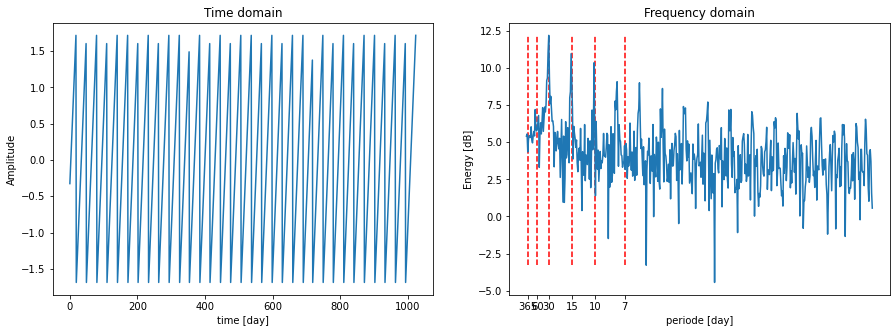

In [14]:
max=None
key = 'day'
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(dfcin[key])
axs[0].set_xlabel("time [day]")
axs[0].set_ylabel("Amplitude")
axs[0].set_title("Time domain")
freq = np.linspace(0.00000000001,1,fte.shape[0])
per = 1/freq
axs[1].plot(freq[1:max],
            np.log(fte[1:max,idxk[key]]))
freq_lab = axs[1].get_xticks()
per_lab = [7,10,15,30,60,365]
freq_ticks = [2/el for el in per_lab]
axs[1].set_xticks(freq_ticks)
axs[1].set_xticklabels(per_lab)
axs[1].set_xlabel("periode [day]")
axs[1].set_ylabel("Energy [dB]")
axs[1].vlines(freq_ticks,
              np.min(np.log(fte[1:200,idxk[key]])),
              np.max(np.log(fte[1:200,idxk[key]])),
              color='r',linestyle='dashed')
axs[1].set_title("Frequency domain")
print("The main frequency component has a period of {:.1f}".format(len(dfci)/np.argmax(fte[:,idxk[key]]))
     +" days")

In [1]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('fourier.pdf')

max = 200
fig,axs = plt.subplots(len(keys_float),2,figsize=(15,4*len(keys_float)),tight_layout=True)
freq = np.linspace(0.00000000001,1,fte.shape[0])
per = 1/freq
for idx,key in enumerate(keys_float):
    axs[idx][0].plot(dfcin[key])
    axs[idx][0].set_xlabel("time [day]")
    axs[idx][0].set_ylabel("Amplitude")
    axs[idx][0].set_title(f"{key}: Time domain")
    
    axs[idx][1].plot(freq[1:max],
                np.log(fte[1:max,idxk[key]]))
    freq_lab = axs[idx][1].get_xticks()
    per_lab = [7,10,15,30,60,365]
    freq_ticks = [2/el for el in per_lab]
    axs[idx][1].set_xticks(freq_ticks)
    axs[idx][1].set_xticklabels(per_lab)
    axs[idx][1].set_xlabel("periode [day]")
    axs[idx][1].set_ylabel("Energy [dB]")
    axs[idx][1].vlines(freq_ticks,
                       np.min(np.log(fte[1:200,idx])),
                       np.max(np.log(fte[1:200,idx])),
                       color='r',linestyle='dashed')
    axs[idx][1].set_title(f"{key}: Frequency domain")
pp.savefig()
pp.close()

NameError: name 'plt' is not defined